# 00. Library Import

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf

import tensorflow_datasets as tfds

# 01. Data Load

In [24]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

# 02. Data preprocessing

## Image preprocessing and augmentation function

### Resizing and Normalization

In [25]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0 # 0~1 사이의 float32로 정규화
    
    return image, label

### label Onehot Encoding

In [26]:
def onehot(image, label):
    onehot_label = tf.one_hot(label, num_classes, on_value=1.0, off_value=0.0)
    
    return image, onehot_label

### Random augmentation (flip, brightness, saturation)

In [27]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    image = tf.image.random_saturation(image, 0.5, 1.5)
    
    return image, label

### Mixup augmentation

In [28]:
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    """두 이미지를 MixUp 방식으로 혼합합니다."""
    # 혼합 비율 선택
    a = tf.random.uniform([], 0, 1)
    
    # 라벨을 원-핫 인코딩
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
        
    mixed_image = (1 - a) * image_a + a * image_b
    mixed_label = (1 - a) * label_a + a * label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    """Batch 내의 이미지를 MixUp 방식으로 혼합합니다."""
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.random.uniform([], 0, batch_size, dtype=tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.stack(mixed_imgs)
    mixed_labels = tf.stack(mixed_labels)
    
    return mixed_imgs, mixed_labels

### Cutmix augmentation

In [29]:
def get_clip_box(image_a, image_b):
    image_size_y = tf.shape(image_a)[0]   # height
    image_size_x = tf.shape(image_a)[1]   # width
    
    x = tf.random.uniform([], minval=0, maxval=tf.cast(image_size_x, tf.float32), dtype=tf.float32)
    y = tf.random.uniform([], minval=0, maxval=tf.cast(image_size_y, tf.float32), dtype=tf.float32)

    box_width = tf.cast(tf.cast(image_size_x, tf.float32) * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    box_height = tf.cast(tf.cast(image_size_y, tf.float32) * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    
    xa = tf.cast(tf.math.maximum(x - tf.cast(box_width, tf.float32) / 2, 0), tf.int32)
    ya = tf.cast(tf.math.maximum(y - tf.cast(box_height, tf.float32) / 2, 0), tf.int32)
    xb = tf.cast(tf.math.minimum(x + tf.cast(box_width, tf.float32) / 2, tf.cast(image_size_x, tf.float32)), tf.int32)
    yb = tf.cast(tf.math.minimum(y + tf.cast(box_height, tf.float32) / 2, tf.cast(image_size_y, tf.float32)), tf.int32)
    
    return xa, ya, xb, yb

def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_y = tf.shape(image_a)[0]
    image_size_x = tf.shape(image_a)[1]
    
    one = image_a[ya:yb, 0:xa, :]
    two = image_b[ya:yb, xa:xb, :]
    three = image_a[ya:yb, xb:image_size_x, :]
    middle = tf.concat([one, two, three], axis=1)
    
    top = image_a[0:ya, :, :]
    bottom = image_a[yb:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom], axis=0)
    
    return mixed_img

def mix_2_labels(label_a, label_b, xa, ya, xb, yb, num_classes=120):    
    image_size_x = 224
    image_size_y = 224
    
    mixed_area = tf.cast((xb - xa) * (yb - ya), tf.float32)
    total_area = tf.cast(image_size_x * image_size_y, tf.float32)
    a = mixed_area / total_area    # a = λ
    
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    
    mixed_label = (1 - a) * label_a + a * label_b
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.random.uniform([], 0, batch_size, dtype=tf.int32)  # 0 <= j < batch_size
        image_b = image[j]  
        label_b = label[j]
        
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_labels(label_a, label_b, xa, ya, xb, yb, num_classes))

    mixed_imgs = tf.stack(mixed_imgs)
    mixed_labels = tf.stack(mixed_labels)
    
    return mixed_imgs, mixed_labels

### Apply preprocessing and optional augmentation

In [30]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    # 기본적인 전처리 함수 적용
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # 데이터 증강 적용
    if not is_test and with_aug:
        ds = ds.map(
            augment,
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
    # 배치 분할
    ds = ds.batch(batch_size)
    
    # MixUp 또는 CutMix 적용
    if not is_test and with_cutmix:
        ds = ds.map(
            lambda x, y: cutmix(x, y, batch_size=batch_size, img_size=224, num_classes=num_classes),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            lambda x, y: mixup(x, y, batch_size=batch_size, img_size=224, num_classes=num_classes),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    else:
        # 라벨을 원-핫 인코딩
        ds = ds.map(
            onehot,
            num_parallel_calls=tf.data.AUTOTUNE
        )

    if not is_test:
        ds = ds.shuffle(200)
        ds = ds.repeat()
        
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

# 03. Create experiment dataset 

In [31]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

### dataset type
#### 1. no augmentation
#### 2. only random augmentation
#### 3. only Mixup augmentation
#### 4. only Cutmix augmentation
#### 5. Mixup + Cutmix augmentation
#### 6. all augmentation

In [32]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

# 데이터셋 전처리 파이프라인 설정
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=False, with_mixup=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=True)
ds_train_mixup_cutmix = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=True, with_mixup=True)
ds_train_all = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True, with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [42]:
for features, labels in ds_train_mixup_cutmix.take(1):
    print(labels[1])

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.5859375 0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [ ]:
def count_elements_in_dataset(dataset):
    return sum(1 for _ in dataset)

# Counting elements in each dataset
ds_train_no_aug_count = count_elements_in_dataset(ds_train_no_aug)
ds_train_aug_count = count_elements_in_dataset(ds_train_aug)
ds_train_mixup_count = count_elements_in_dataset(ds_train_mixup)
ds_train_cutmix_count = count_elements_in_dataset(ds_train_cutmix)
ds_train_mixup_cutmix_count = count_elements_in_dataset(ds_train_mixup_cutmix)
ds_train_all_count = count_elements_in_dataset(ds_train_all)
ds_test_count = count_elements_in_dataset(ds_test)

ds_counts = {
    "ds_train_no_aug_count": ds_train_no_aug_count,
    "ds_train_aug_count": ds_train_aug_count,
    "ds_train_mixup_count": ds_train_mixup_count,
    "ds_train_cutmix_count": ds_train_cutmix_count,
    "ds_train_mixup_cutmix_count": ds_train_mixup_cutmix_count,
    "ds_train_all_count": ds_train_all_count,
    "ds_test_count": ds_test_count
}

# Display the results
print(ds_counts)

# 04. Build Model

### ResNet50  Model (loss=caregorical_crossentropy)

In [13]:
# 모델 생성 함수
def build_resnet50_model(input_shape=(224, 224, 3), num_classes=120, model_name="resnet50", initial_lr=0.01):
    inputs = keras.Input(shape=input_shape)
    base_model = keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling='avg'
    )
    x = base_model.output
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.SGD(learning_rate=initial_lr),
        metrics=['accuracy']
    )
    return model

### Callbacks function

In [14]:
# 체크포인트, 얼리스타핑, TensorBoard, 러닝 레이트 스케줄러 콜백 설정
def create_callbacks(model_name, log_dir="logs", scheduler_type=None, initial_lr=0.01):
    # 체크포인트 콜백
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f'best_{model_name}.h5',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )

    # 얼리스타핑 콜백
    early_stopping_cb = keras.callbacks.EarlyStopping(
        patience=20,
        restore_best_weights=True,
        monitor='val_accuracy',
        mode='max'
    )

    # 텐서보드 콜백
    tensorboard_cb = keras.callbacks.TensorBoard(
        log_dir=log_dir,
        write_graph=True,
        write_images=True,
        update_freq='batch'
    )
    
    callbacks = [checkpoint_cb, early_stopping_cb, tensorboard_cb]
    
    return callbacks

### logger function -> to save and visualization result

In [15]:
class IterationLogger(keras.callbacks.Callback):
    def __init__(self, log_path='iteration_logs.csv'):
        super().__init__()
        self.log_path = log_path
        self.logs = []
        self.iterations = []

    # 에포크가 끝날 때 로그를 저장
    def on_epoch_end(self, epoch, logs=None):
        iteration = self.model.optimizer.iterations.numpy()
        self.iterations.append(iteration)
        
        # 로그 저장: train_loss, val_loss, val_accuracy
        log_data = {
            'iteration': iteration,
            'train_loss': logs.get('loss'),
            'val_loss': logs.get('val_loss'),
            'val_accuracy': logs.get('val_accuracy'),
            '1-val_accuracy': 1 - logs.get('val_accuracy') if logs.get('val_accuracy') else None
        }
        self.logs.append(log_data)

        # CSV 파일에 실시간 저장
        df = pd.DataFrame(self.logs)
        df.to_csv(self.log_path, index=False)

    # 시각화 함수
    def plot(self):
        df = pd.DataFrame(self.logs)

        # train_loss와 val_loss 시각화
        plt.figure(figsize=(10, 5))
        plt.plot(df['iteration'], df['train_loss'], label='train_loss')
        plt.plot(df['iteration'], df['val_loss'], label='val_loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # 1 - val_accuracy 및 val_accuracy 시각화
        plt.figure(figsize=(10, 5))
        plt.plot(df['iteration'], df['1-val_accuracy'], label='1 - val_accuracy')
        plt.plot(df['iteration'], df['val_accuracy'], label='val_accuracy')
        plt.xlabel('Iterations')
        plt.ylabel('Accuracy/Error')
        plt.legend()
        plt.show()

# 05. Training Model

### training fuction

In [16]:
# 모델 학습 함수
def train_model(dataset, validation_data, num_classes, epochs=50, model_name="resnet50", log_dir="logs", scheduler_type=None, initial_lr=0.01):
    # 모델 생성
    model = build_resnet50_model(num_classes=num_classes, model_name=model_name, initial_lr=initial_lr)

    iter_logger = IterationLogger(log_path=f'{model_name}_iteration_logs.csv')
    callbacks = create_callbacks(model_name=model_name, log_dir=log_dir, scheduler_type=scheduler_type, initial_lr=initial_lr) + [iter_logger]
    
    # 모델 훈련
    history = model.fit(
        dataset,
        steps_per_epoch=int(ds_info.splits['train'].num_examples / 16),  # 배치 사이즈에 맞게 수정 (배치 사이즈=16)
        validation_data=validation_data,
        validation_steps=int(ds_info.splits['test'].num_examples / 16),  # 배치 사이즈에 맞게 수정 (배치 사이즈=16)
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
        # use_multiprocessing=True  # 멀티프로세싱은 데이터셋과 콜백에 따라 문제가 발생할 수 있음. 필요 시 활성화
    )
    # iteration별로 저장된 데이터 시각화
    iter_logger.plot()

    return model, history

In [17]:
EPOCHS = 50
LOG_DIR = "logs"

### 05_1. no augmentation

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/50
  6/750 [..............................] - ETA: 3:12 - loss: 5.0508 - accuracy: 0.0208WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0869s vs `on_train_batch_end` time: 0.1441s). Check your callbacks.


750/750 [==============================] - 207s 207ms/step - loss: 2.2217 - accuracy: 0.4369 - val_loss: 3.4444 - val_accuracy: 0.1982
Epoch 2/50
750/750 [==============================] - 168s 224ms/step - loss: 0.7690 - accuracy: 0.7823 - val_loss: 1.3301 - val_accuracy: 0.6217
Epoch 3/50
750/750 [==============================] - 154s 205ms/step - loss: 0.2317 - accuracy: 0.9538 - val_loss: 0.9791 - val_accuracy: 0.7107
Epoch 4/50
750/750 [==============================] - 153s 204ms/step - loss: 0.0689 - accuracy: 0.9942 - val_loss: 0.9391 - val_accuracy: 0.7334
Epoch 5/50
750/750 [==============================] - 153s 204ms/step - loss: 0.0266 - accuracy: 0.9992 - val_loss: 0.9011 - val_accuracy: 0.7414
Epoch 6/50
750/750 [==============================] - 153s 205ms/step - loss: 0.0173 - accuracy: 0.9998 - val_loss: 0.9158 - val_accuracy: 0.7456
Epoch 7/50
750/750 [==============================] - 154s 205ms/step - loss: 0.0123 - accuracy: 0.9998 - val_loss: 0.9267 - val_accura

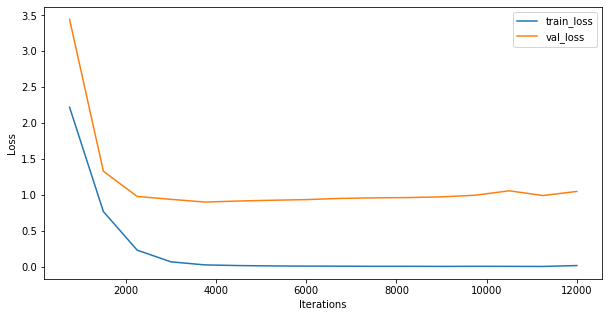

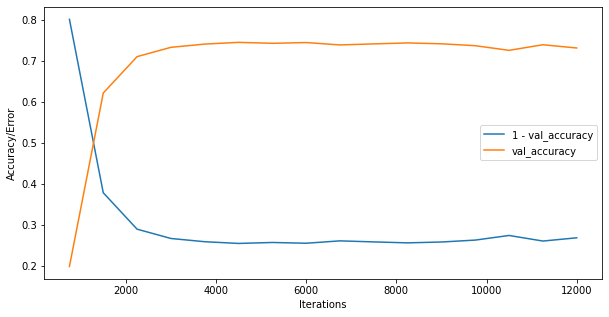

In [16]:
# augmentation 적용하지 않은 데이터셋
model_no_aug, history_no_aug = train_model(ds_train_no_aug, ds_test, num_classes=num_classes, epochs=EPOCHS, model_name="resnet50_no_aug", log_dir=f"{LOG_DIR}/no_aug")

### 05_2. random augmentation

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/50
  6/750 [..............................] - ETA: 5:24 - loss: 5.2157 - accuracy: 0.0312WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1073s vs `on_train_batch_end` time: 0.2748s). Check your callbacks.


750/750 [==============================] - 167s 209ms/step - loss: 2.3583 - accuracy: 0.4118 - val_loss: 2.6848 - val_accuracy: 0.3169
Epoch 2/50
750/750 [==============================] - 154s 206ms/step - loss: 1.0430 - accuracy: 0.6956 - val_loss: 1.3132 - val_accuracy: 0.6250
Epoch 3/50
750/750 [==============================] - 158s 210ms/step - loss: 0.5801 - accuracy: 0.8362 - val_loss: 1.4510 - val_accuracy: 0.5956
Epoch 4/50
750/750 [==============================] - 154s 206ms/step - loss: 0.3902 - accuracy: 0.8952 - val_loss: 1.2732 - val_accuracy: 0.6405
Epoch 5/50
750/750 [==============================] - 154s 205ms/step - loss: 0.2032 - accuracy: 0.9542 - val_loss: 1.2052 - val_accuracy: 0.6637
Epoch 6/50
750/750 [==============================] - 154s 206ms/step - loss: 0.1159 - accuracy: 0.9788 - val_loss: 0.9827 - val_accuracy: 0.7317
Epoch 7/50
750/750 [==============================] - 154s 205ms/step - loss: 0.0727 - accuracy: 0.9897 - val_loss: 1.1259 - val_accura

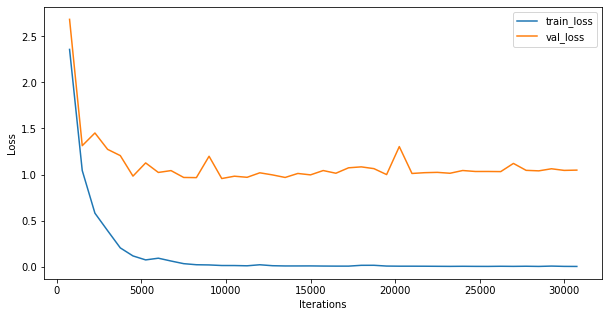

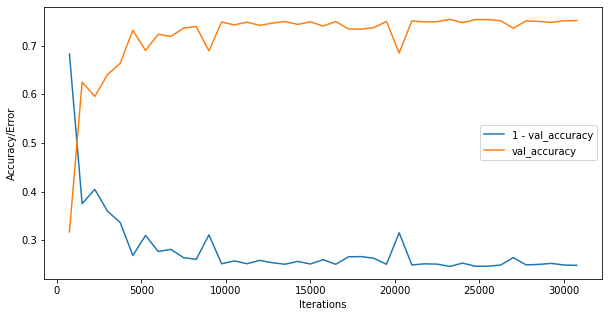

In [17]:
# augmentation 적용한 데이터셋
model_aug, history_aug = train_model(ds_train_aug, ds_test, num_classes=num_classes, epochs=EPOCHS, model_name="resnet50_aug", log_dir=f"{LOG_DIR}/aug")

### 05_3. only Mixup augmentation

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/50
750/750 [==============================] - 203s 210ms/step - loss: 3.7528 - accuracy: 0.2323 - val_loss: 3.9119 - val_accuracy: 0.1210
Epoch 2/50
750/750 [==============================] - 157s 209ms/step - loss: 2.8728 - accuracy: 0.4744 - val_loss: 1.4276 - val_accuracy: 0.5976
Epoch 3/50
750/750 [==============================] - 157s 209ms/step - loss: 2.5749 - accuracy: 0.5846 - val_loss: 1.3752 - val_accuracy: 0.6187
Epoch 4/50
750/750 [==============================] - 157s 209ms/step - loss: 2.4075 - accuracy: 0.6511 - val_loss: 1.3173 - val_accuracy: 0.6311
Epoch 5/50
750/750 [==============================] - 172s 229ms/step - loss: 2.2475 - accuracy: 0.7102 - val_loss: 1.3920 - val_accuracy: 0.6205
Epoch 6/50
750/750 [==============================] - 157s 209ms/step - loss: 2.1671 - accuracy: 0.7424 - val_loss: 1.3179 - val_accuracy: 0.6473
Epoch 7/50
750/750 [==============================] - 156s 209ms/step - loss: 2.0707 - accuracy: 0.7804 - val_loss: 1.2809 -

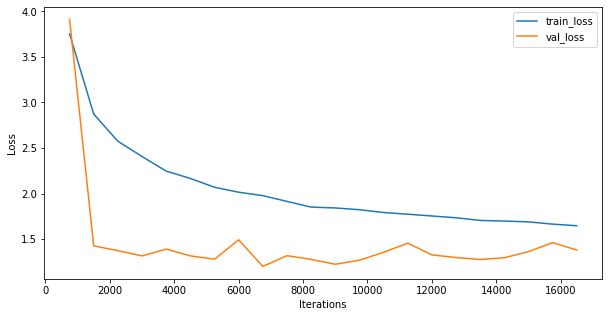

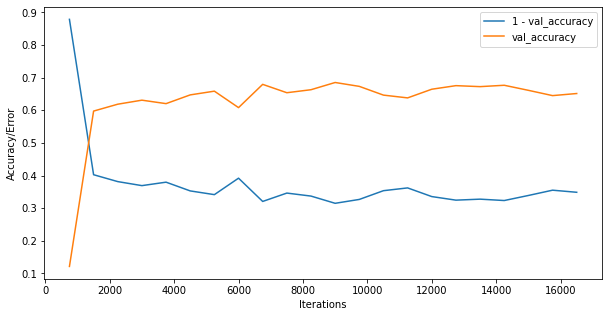

In [18]:
# mixup만 적용한 데이터ss셋
model_mixup, history_mixup = train_model(ds_train_mixup, ds_test, num_classes=num_classes, epochs=EPOCHS, model_name="resnet50_mixup", log_dir=f"{LOG_DIR}/mixup")

### 05_4. only Cutmix augmentation

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/50
750/750 [==============================] - 166s 211ms/step - loss: 3.8467 - accuracy: 0.2058 - val_loss: 3.4091 - val_accuracy: 0.1919
Epoch 2/50
750/750 [==============================] - 157s 209ms/step - loss: 2.9286 - accuracy: 0.4333 - val_loss: 1.3981 - val_accuracy: 0.6090
Epoch 3/50
750/750 [==============================] - 157s 209ms/step - loss: 2.6094 - accuracy: 0.5483 - val_loss: 1.3964 - val_accuracy: 0.6187
Epoch 4/50
750/750 [==============================] - 157s 209ms/step - loss: 2.3996 - accuracy: 0.6161 - val_loss: 1.2384 - val_accuracy: 0.6583
Epoch 5/50
750/750 [==============================] - 157s 209ms/step - loss: 2.2526 - accuracy: 0.6628 - val_loss: 1.1882 - val_accuracy: 0.6804
Epoch 6/50
750/750 [==============================] - 172s 229ms/step - loss: 2.1253 - accuracy: 0.7045 - val_loss: 1.1445 - val_accuracy: 0.6939
Epoch 7/50
750/750 [==============================] - 157s 209ms/step - loss: 2.0160 - accuracy: 0.7347 - val_loss: 1.1265 -

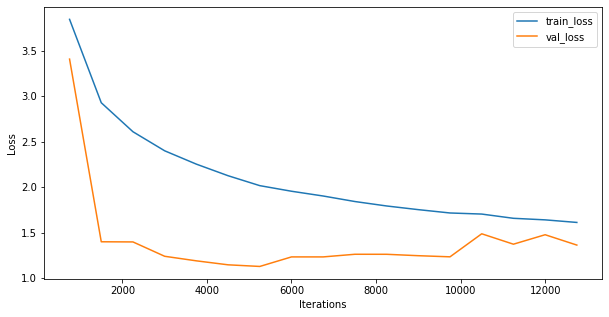

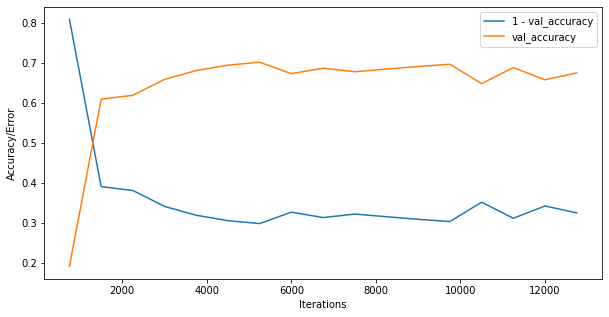

In [19]:
# cutmix만 적용한 데이터셋
model_cutmix, history_cutmix = train_model(ds_train_cutmix, ds_test, num_classes=num_classes, epochs=EPOCHS, model_name="resnet50_cutmix", log_dir=f"{LOG_DIR}/cutmix")

### 05_5. Mixup + Cutmix augmentation

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/50
750/750 [==============================] - 166s 211ms/step - loss: 3.8320 - accuracy: 0.2082 - val_loss: 3.6626 - val_accuracy: 0.1761
Epoch 2/50
750/750 [==============================] - 157s 209ms/step - loss: 2.9393 - accuracy: 0.4349 - val_loss: 1.3577 - val_accuracy: 0.6208
Epoch 3/50
750/750 [==============================] - 157s 209ms/step - loss: 2.6052 - accuracy: 0.5370 - val_loss: 1.2504 - val_accuracy: 0.6512
Epoch 4/50
750/750 [==============================] - 157s 209ms/step - loss: 2.4072 - accuracy: 0.6000 - val_loss: 1.2740 - val_accuracy: 0.6455
Epoch 5/50
750/750 [==============================] - 156s 209ms/step - loss: 2.2344 - accuracy: 0.6594 - val_loss: 1.2073 - val_accuracy: 0.6695
Epoch 6/50
750/750 [==============================] - 157s 209ms/step - loss: 2.1272 - accuracy: 0.7034 - val_loss: 1.3916 - val_accuracy: 0.6250
Epoch 7/50
750/750 [==============================] - 156s 209ms/step - loss: 2.0380 - accuracy: 0.7259 - val_loss: 1.2485 -

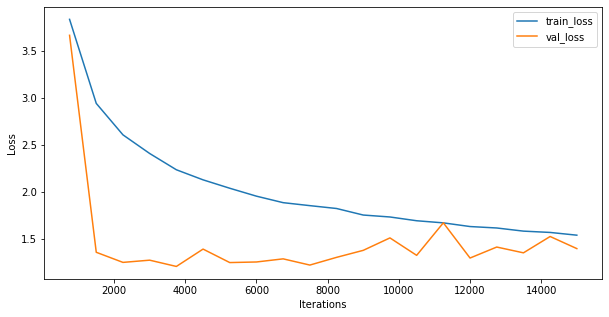

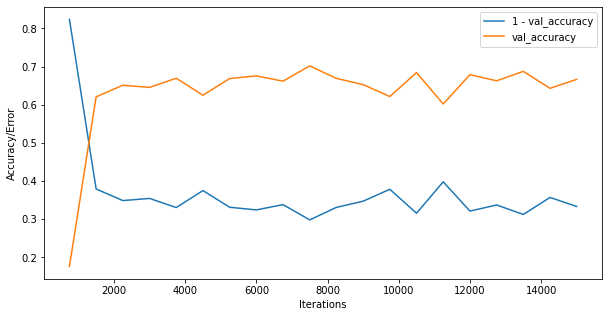

In [20]:
# mixup과 cutmix를 동시에 적용한 데이터셋
model_mixup_cutmix, history_mixup_cutmix = train_model(ds_train_mixup_cutmix, ds_test, num_classes=num_classes, epochs=EPOCHS, model_name="resnet50_mixup_cutmix", log_dir=f"{LOG_DIR}/mixup_cutmix")

### 05_6. all augmentation

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/50
750/750 [==============================] - 168s 211ms/step - loss: 3.8841 - accuracy: 0.2021 - val_loss: 3.0999 - val_accuracy: 0.2480
Epoch 2/50
750/750 [==============================] - 157s 209ms/step - loss: 3.0655 - accuracy: 0.3875 - val_loss: 1.6548 - val_accuracy: 0.5382
Epoch 3/50
750/750 [==============================] - 157s 209ms/step - loss: 2.7877 - accuracy: 0.4803 - val_loss: 1.4479 - val_accuracy: 0.6000
Epoch 4/50
750/750 [==============================] - 157s 209ms/step - loss: 2.6237 - accuracy: 0.5337 - val_loss: 1.2458 - val_accuracy: 0.6549
Epoch 5/50
750/750 [==============================] - 157s 209ms/step - loss: 2.4782 - accuracy: 0.5775 - val_loss: 1.2371 - val_accuracy: 0.6590
Epoch 6/50
750/750 [==============================] - 157s 209ms/step - loss: 2.3630 - accuracy: 0.6075 - val_loss: 1.2208 - val_accuracy: 0.6592
Epoch 7/50
750/750 [==============================] - 172s 230ms/step - loss: 2.2653 - accuracy: 0.6403 - val_loss: 1.1460 -

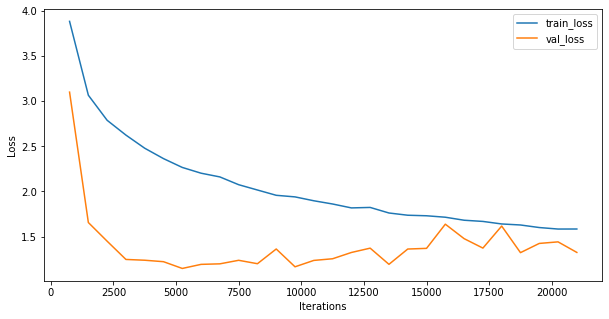

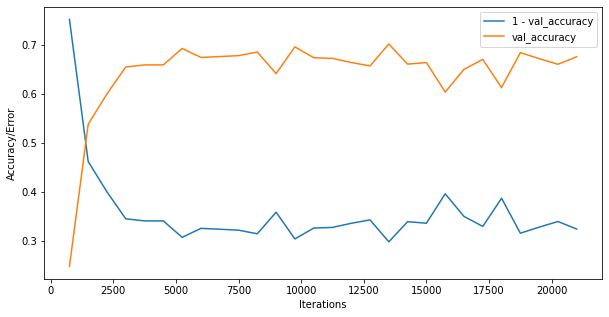

In [21]:
# 전체 증강을 동시에 적용한 데이터셋
model_all, history_all = train_model(ds_train_all, ds_test, num_classes=num_classes, epochs=EPOCHS, model_name="resnet50_all", log_dir=f"{LOG_DIR}/all")

# 06. Visualization of result

In [45]:
no_aug = pd.read_csv("./resnet50_no_aug_iteration_logs.csv")
aug = pd.read_csv("./resnet50_aug_iteration_logs.csv")
mixup = pd.read_csv("./resnet50_mixup_iteration_logs.csv")
cutmix = pd.read_csv("./resnet50_cutmix_iteration_logs.csv")
mixup_cutmix = pd.read_csv("./resnet50_mixup_cutmix_iteration_logs.csv")
aug_all = pd.read_csv("./resnet50_all_iteration_logs.csv")

aug_list=[no_aug, aug, mixup, cutmix, mixup_cutmix, aug_all ]

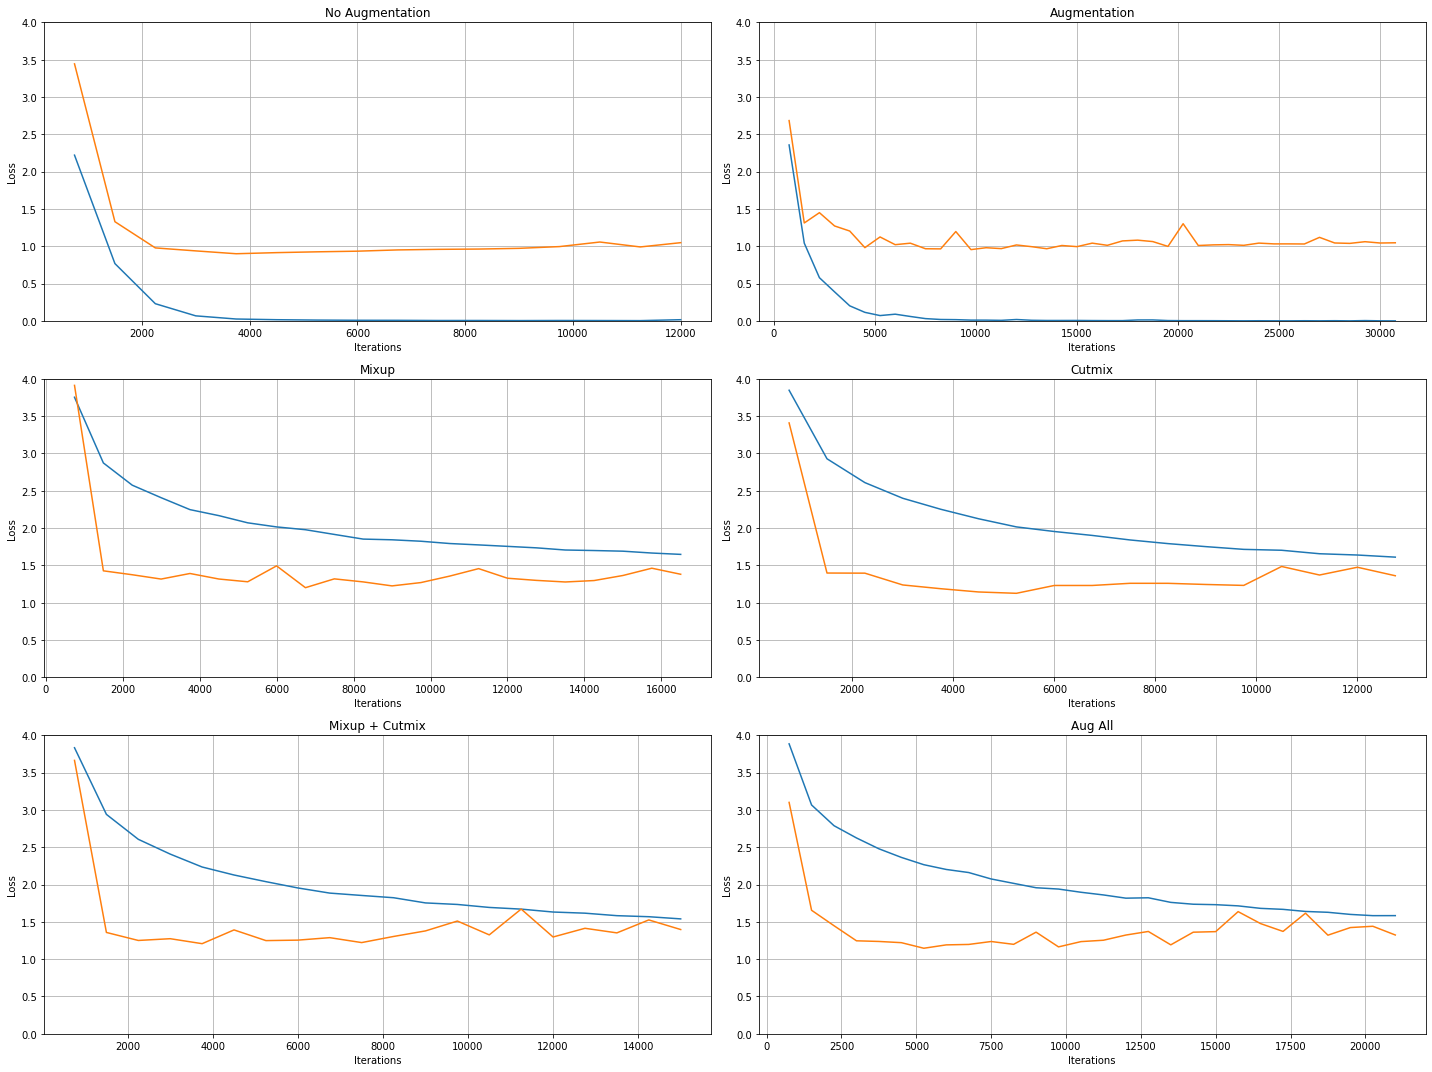

In [46]:
titles = ['No Augmentation', 'Augmentation', 'Mixup', 'Cutmix', 'Mixup + Cutmix', 'Aug All']

plt.figure(figsize=(20, 15))
for i in range(len(aug_list)):
    df = aug_list[i]
    plt.subplot(3, 2, i + 1) 
    plt.plot(df['iteration'], df['train_loss'], label='train_loss')
    plt.plot(df['iteration'], df['val_loss'], label='val_loss')
    
    plt.title(titles[i])
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    
    plt.grid(True)
    plt.ylim(0, 4)
    
plt.tight_layout()
plt.show()

## 결과 분석 (loss 비교)
### 총 6개(original data, random aug, mixup, cutmix, mixup+cutmix, all aug)의 datasets를 생성하여 실험을 진행하였다. 우선 학습 손실과 검증 손실을 각 실험 별로 비교하였다. 증강이 없을 때와 랜덤 증강을 적용했을때의 학습 손실은 검증 손실 보다 낮은 양상을 볼수 있다. 이를 제외한 mixup과 cutmix를 적용하였을 때는 검증 손실이 더 낮음을 확인할 수 있다. mixup과 cutmix가 배치별로 이미지와 라벨을 섞어 진행하므로 모델 학습의 복잡도가 증가함을 확실히 확인할 수 있다.
### 특히 mixup을 적용하였을 때가 가장 학습 손실과 검증 손실에 차이가 크다는 것을 확인할 수 있다. 이는 mixup의 정보 손실이 cutmix에 비해 크다는 것을 확인할 수 있다. ( + mixup 기법은 경계를 불분명하게 하며 실제 활성화 히트맵을 확인하여도 라벨의 겹치는 정도가 크고 불분명한 경계로인해 분류를 제외하고는 적용이 어렵다는 단점도 존재한다.)

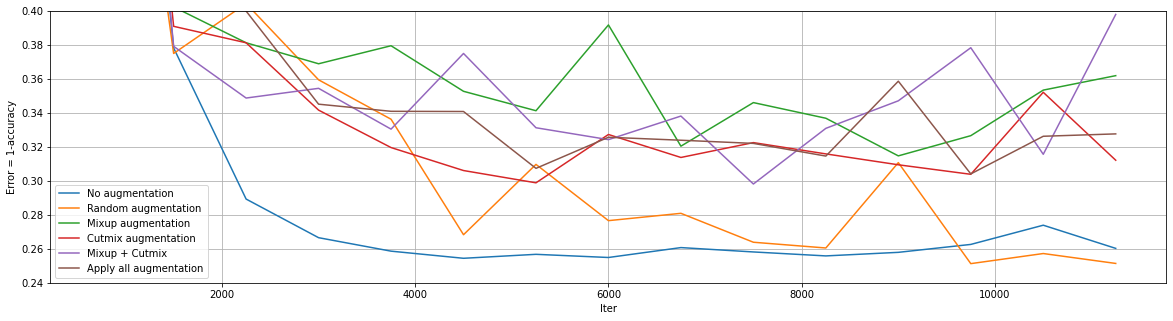

In [47]:
num_epochs = 15

plt.figure(figsize=(20, 5))
plt.plot(no_aug['iteration'][:num_epochs], no_aug['1-val_accuracy'][:num_epochs], label='No augmentation')
plt.plot(aug['iteration'][:num_epochs], aug['1-val_accuracy'][:num_epochs], label='Random augmentation')
plt.plot(mixup['iteration'][:num_epochs], mixup['1-val_accuracy'][:num_epochs], label='Mixup augmentation')
plt.plot(cutmix['iteration'][:num_epochs], cutmix['1-val_accuracy'][:num_epochs], label='Cutmix augmentation')
plt.plot(mixup_cutmix['iteration'][:num_epochs], mixup_cutmix['1-val_accuracy'][:num_epochs], label='Mixup + Cutmix')
plt.plot(aug_all['iteration'][:num_epochs], aug_all['1-val_accuracy'][:num_epochs], label='Apply all augmentation')

plt.xlabel('Iter')
plt.ylabel('Error = 1-accuracy')
plt.grid(True)
plt.ylim(0.24, 0.4) 
plt.legend()
plt.show()

## 결과분석(error 비교)
### 증강을 하지 않은 데이터에 비해 증강을 한 데이터가 결과적으로 높은 정확도를 기록하였다. cutmix와 mixup 증강을 적용하여 복잡도가 증가한 모델에 대해서는 상대적으로 낮은 정확도가 나오는 결과를 얻었다. 논문과 비교해서는 증강 기법의 효과가 없었다는 해석이 나온다....
### 그러나 mixup과 cutmix를 비교하였을 때는 cut mix가 높은 성능을 기록함을 확인 할 수 있었다.

## 고찰
### 왜 논문 내용과는 다르게 mixup과 cutmix가 높은 성능을 얻지 못했는가?
###  아직 lr 스케쥴러를 정의하지 않기도 하였으며 시간적 한계로 많은 epoch 수를 돌릴 수 없어 early stopping을 적용하였다. 이를 통해 학습에 많은 시간이 필요함을 확인할 수 있다. 아직 학습 최적지점을 찾지 못했을 가능성이 있다. 또한 복잡도가 증가한 모델일 수록 학습률을 따로 조정하는 방법도 적용해봐야할 것이라 판단했다.
### Mixup과 CutMix의 α(λ) 값 조정을 통해 원래 이미지의 많은 손실이 발생할 경우를 줄여야한다고 판단했다.

### 논문 내용과는 조금 다른 비교를 진행한 것 같지만 그래도 분석을 통해 얻은 인사이트가 많아 도움이 되었다. 